In [1]:
#disable warnings
import warnings
warnings.filterwarnings("ignore") 

# Purpose of this Notebook

In [2]:
#Number of reviews to put into data frame of good reviews. Set it to less than 0 if you want all of the good reviews to be processed
NUMB_OF_GOOD_REVIEWS = -1

#Number of reviews to put into data frame of bad reviews
NUMB_OF_BAD_REVIEWS = -1

#set to 1 if you want to reclean the dataframes, otherwise it will load data from a previous clean
#note cleaning takes 30 minutes on a pretty fast machine
CLEAN_DATAFRAME = 0

#used to seed the random state in parts of the NLP pipeline that need it
RANDOM_STATE=42

#the max number of processors to use in parallel for performing certain text processing steps in the NLP pipeline
N_JOBS = 32


#number of topics to generate in the document-term matrix created via LDA
NUMBER_OF_TOPICS=20

#Set to 1 if you want to generate scatter plots of the entire set of bad and good reviews (1 plot for the bad reviews, 1 plot for the good reviews). 
#WARNING this will take about 12 hours to generate
GENERATE_FULL_SCATTER_PLOT = 0

## Problem Statement

Product developers often want to know this about their products:

* For products that people don't like, what is it about the products they don't like? Maybe if we know this we could improve the product by fixing this unliked product features
* For products that people love, what is it about the products that result in people loving them? Maybe if we expanded on these loved features, we could get new customers or better retain current customers

## Proposed Solution

Perform [topic modeling ](https://en.wikipedia.org/wiki/Topic_model) that helps product managers identify the features of products that people love so that a product manager can have an idea of things that could be addressed to get more "likes" for the product.

Perform topic modeling that helps product managers pinpoint features of products that people don't like so that a product manager can determine what could be fixed to hopefully turn the disliked product into a liked product.


# Module Import

In [3]:
import datetime
from collections import Counter
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

#to speed up pandas operands
from pandarallel import pandarallel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#code to perform tSNE plots
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)

# Import seaborn and matplotlib.patheffects to make nice plots.
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})





In [4]:
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'png'
%matplotlib inline 

# NLP Pipeline

This section of the notebook steps through the various stages of text processing starting with initial raw text read in from the CSV file and ends with the TFIDF-vectorized document-term matrix.


## Text Preprocessing

This diagram describes what is happening in the early parts of the document processing pipeline:

![text_preproc](./../Documents/Images/text_preprocessing.jpg)

**Deduplication**: Removed any rows in the original CSV that are duplicates. See code below for more on how duplicates were chosen.

**NaN Removal**: Removed any row in the original CSV that contained one or more `NaN` (not a number) entries or where `HelpfulnessDenominator==0`.

**Cleaning**: Removed HTML and non-English words (according to NLTK's dictionary), removed punctuation, removed numbers, or space-delimited strings that contain numbers, converted what remains to lowercase

**Tokenization**: Converted the review, which exists as a single string, into separate strings, one string per word as identified by NLTK's `word_tokenize()`

**Lemmatization**: Convert each word into its equivalent form found in the dictionary using NLTK's `WordNetLemmatizer()`

Rationale for all of this processing: To reduce the impact of the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality), and to not steer subsequent analysis steps to operate on misspelled words.

For example the word "buying" and "bought" both appear in the review corpus. Both of these words are variations of the dictionary term "buy" and hence mean the same thing. If we were to allow all three terms to be analyzed it woud result in a matrix, where each document would be defined by three extra vector components when just one would suffice. Adding these extra terms increases the sparsity of the resultant document-term matrix which makes it harder given the fixed data set.

The downside of this processing is that there are meaningful terms, that because they do not exist in the dictionary, are removed. For example the term [zubaz](https://en.wikipedia.org/wiki/Curse_of_dimensionality) is removed from the corpus. This and other similar terms could be added back by manually expanding the set of terms in the NLTK dictionary, given more engineering time.


In [5]:
reviews_df = pd.read_csv("../Data/Reviews.csv")



In [6]:
reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
reviews_df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


According to the [Kaggle description](https://www.kaggle.com/snap/amazon-fine-food-reviews) of the dataset `HelpfulnessNumerator` should be less than or equal to `HelpfulnessDenominator`. So I will filter out any reviews that do not meet this specification.  Also, removing reviews where `HelpfulnessDenominator` is zero as this indicates a review that is not useful:

In [8]:
#reviews that don't satify the filter-out specification and are thus, valid
mask = (reviews_df["HelpfulnessNumerator"] <=  reviews_df["HelpfulnessDenominator"]) & (reviews_df["HelpfulnessDenominator"] > 0)
reviews_df[~mask].shape

(270054, 10)

There are few to remove so doing that now:

In [9]:
reviews_df = reviews_df[mask]

**Deduplication**: Are there any duplicate entries?

In [10]:
reviews_df.duplicated(subset=["UserId","ProfileName","Time","Text"],keep="first").value_counts()

False    209681
True      88719
dtype: int64

In [11]:
reviews_df.drop_duplicates(subset=["UserId","ProfileName","Time","Text"],keep="first",inplace=True)


**NaN Removal**

In [12]:
reviews_df.dropna(inplace=True)

Speculative EDA: calculating a helpfulness metric in the hopes that it helps separate reviews.

In [13]:
reviews_df["helpful_rating"] = reviews_df["HelpfulnessNumerator"] / reviews_df["HelpfulnessDenominator"]

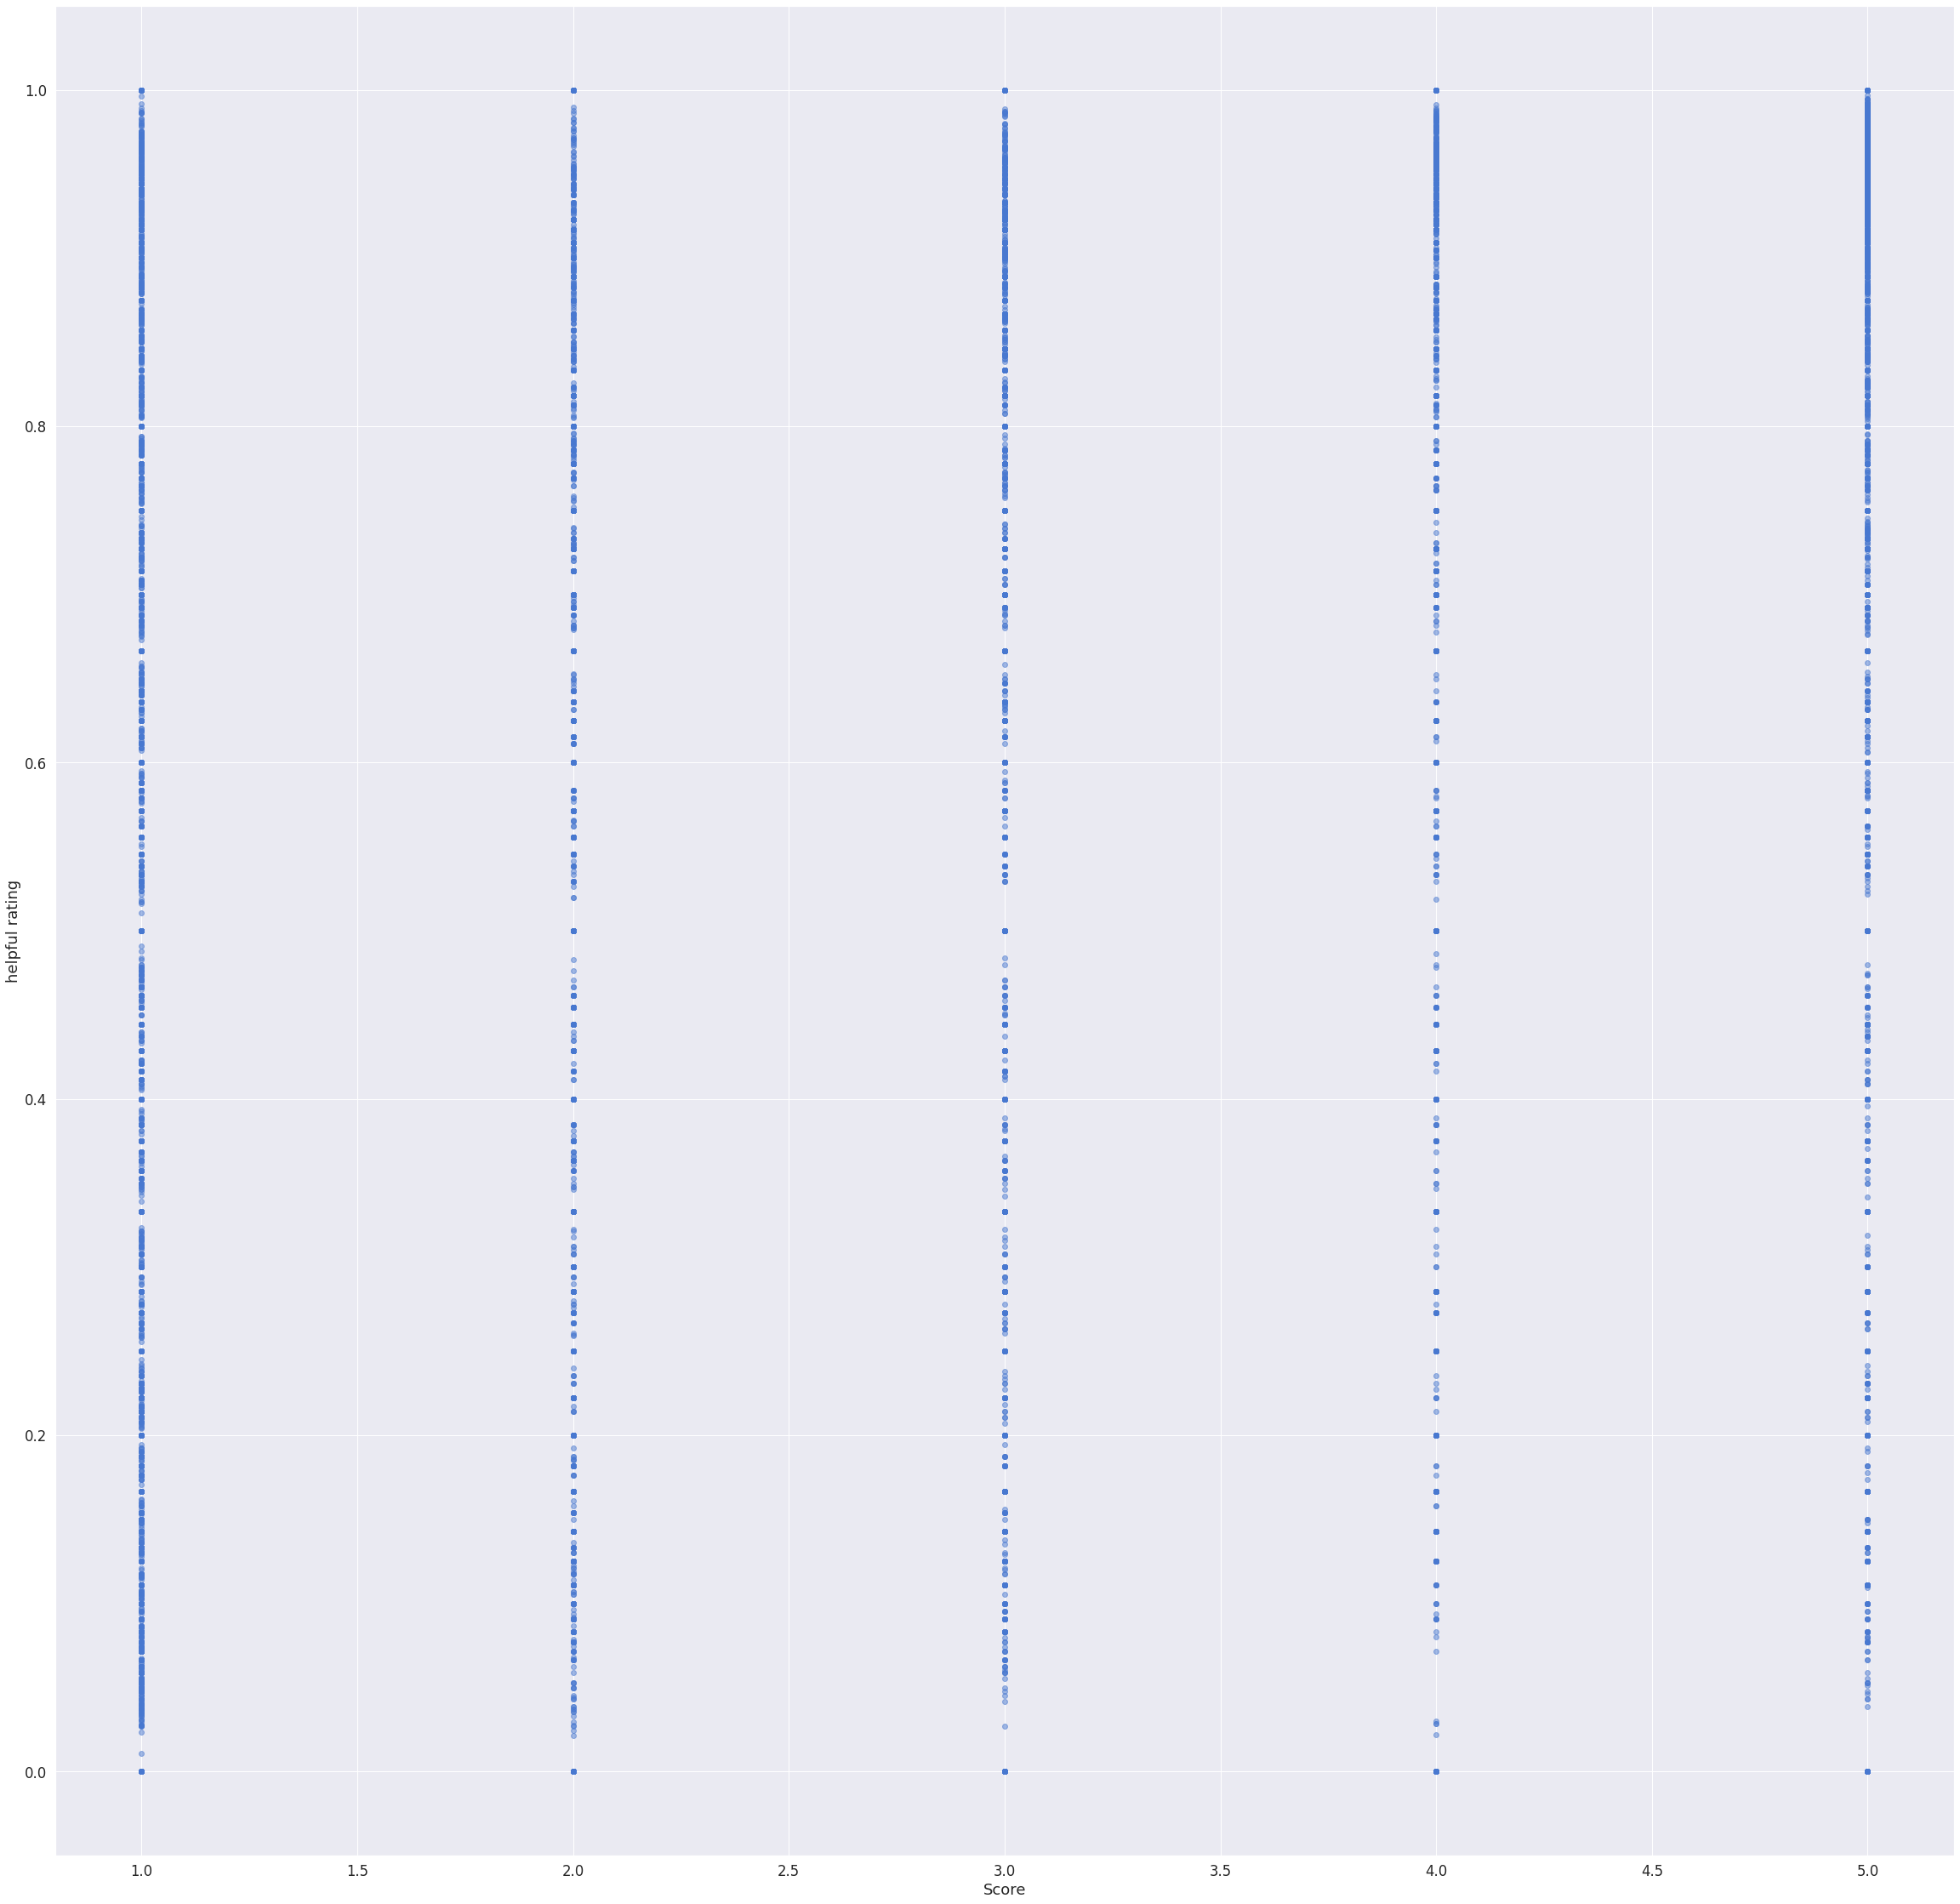

In [14]:
plt.figure(figsize=(40,40))
plt.scatter(reviews_df["Score"],reviews_df["helpful_rating"],alpha=0.5)
plt.xlabel("Score")
plt.ylabel("helpful rating")
plt.show();

This small bit of EDA does not yield any useful separation of reviews. Will not pursue anymore EDA for now.

Going to create a dataframe of bad reviews and one of good reviews to process separately. I remove reviews where "Score" == 3 because these do not indicate a call to action to either improve a bad product or point out a product that likely has nice features.



In [15]:
good_reviews_df = reviews_df[ reviews_df["Score"] >= 4 ]
bad_reviews_df = reviews_df[ reviews_df["Score"] <= 2 ]

In [16]:
if (NUMB_OF_GOOD_REVIEWS > good_reviews_df.shape[0]) or (NUMB_OF_GOOD_REVIEWS < 0):
    NUMB_OF_GOOD_REVIEWS = good_reviews_df.shape[0]


if (NUMB_OF_BAD_REVIEWS > bad_reviews_df.shape[0]) or (NUMB_OF_BAD_REVIEWS < 0):
    NUMB_OF_BAD_REVIEWS = bad_reviews_df.shape[0]

In [17]:
good_reviews_df = good_reviews_df[:(NUMB_OF_GOOD_REVIEWS + 1)]
bad_reviews_df = bad_reviews_df[:(NUMB_OF_BAD_REVIEWS + 1)]

This is the function used to perform the **Cleaning** step described above.

In [18]:
#Removing HTML from the text
#stuff = [re.sub("<.*?>","",item) for item in stuff]

def remove_html_punct(row):
    """This function removes HTML and punctuation and anything that is or contains a number from the Text"""
    
    NLTK_WORDS = set(nltk.corpus.words.words())
    
    text_to_process = row["Text"]
    text_to_process = text_to_process.lower()
    text_to_process = re.sub("<.*?>","",text_to_process)
    text_to_process = re.sub("[\.|\!|\?|\,|\;|\:|\&|\(|\)|\-|\%|_]","",text_to_process)
    text_to_process = re.sub("\w*\d+\w*","",text_to_process)
    text_to_process_list = text_to_process.split()
    text_to_process_list = [review_word for review_word in text_to_process_list if review_word in NLTK_WORDS]
    text_to_process = " ".join(text_to_process_list)
    return text_to_process



In [19]:
if CLEAN_DATAFRAME == 1:

    #TODO If you have time - convert it to a SQL query
    pandarallel.initialize()

    start_time = datetime.datetime.now()

    good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(remove_html_punct,axis=1)
    bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(remove_html_punct,axis=1)
    end_time = datetime.datetime.now()
    print("time spent doing operation is {}".format(end_time - start_time))
else:
    print("skipping cleaning the data frame.")

skipping cleaning the data frame.


It takes a long time to perform this operation so going to save it to a pickle file if I ever need to rerun but don't need to do this cleaning step.

In [20]:
if CLEAN_DATAFRAME == 1:
    
    GOOD_REVIEWS_FILE = open("../Data/good_reviews.pkl","wb")
    BAD_REVIEWS_FILE = open("../Data/bad_reviews.pkl","wb")
    pickle.dump(good_reviews_df, GOOD_REVIEWS_FILE)
    pickle.dump(bad_reviews_df, BAD_REVIEWS_FILE)
    BAD_REVIEWS_FILE.close()
    GOOD_REVIEWS_FILE.close()
    
else:
    
    GOOD_REVIEWS_FILE = open("../Data/good_reviews.pkl","rb")
    BAD_REVIEWS_FILE = open("../Data/bad_reviews.pkl","rb")
    good_reviews_df = pickle.load(GOOD_REVIEWS_FILE)
    bad_reviews_df = pickle.load(BAD_REVIEWS_FILE)
    

In [21]:
good_reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpful_rating,ProcessedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,i have bought several of the vitality canned d...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,this is a confection that been around a few it...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0,right now mostly just sprouting this so my can...
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1.0,i know if the or the tequila or just the uniqu...
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,1.0,one of my to lose some weight and the other i ...


In [22]:
bad_reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpful_rating,ProcessedText
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,if you are looking for the secret ingredient i...
12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,1.0,my have been happily eating platinum for more ...
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",0.0,the candy is just red no flavor just plan and ...
50,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,1,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",0.0,this oatmeal is not good its mushy soft i like...
62,63,B001EO5TPM,A1E09XGZUR78C6,gary sturrock,2,2,1,1215302400,stale product.,Arrived in 6 days and were so stale i could no...,1.0,in days and were so stale i could not eat any ...


In [23]:
good_reviews_df.reset_index(inplace=True)

Demonstrating here what the original review `Text` looks like compared to the `ProcessedText` at this point.

In [24]:
good_reviews_df.loc[0,"Text"]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [25]:
good_reviews_df.loc[0,"ProcessedText"]

'i have bought several of the vitality canned dog food and have found them all to be of good quality the product more like a stew than a meat and it better my is and she this product better than most'

In [26]:
bad_reviews_df.reset_index(inplace=True)

In [27]:
bad_reviews_df.loc[0,"Text"]

'If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor is very medicinal.'

In [28]:
bad_reviews_df.loc[0,"ProcessedText"]

'if you are looking for the secret ingredient in i believe i have found it i got this in addition to the root beer extract i ordered which was good and made some cherry soda the flavor is very medicinal'

**Tokenization**

In [29]:
def tokenize_text(row):
    temp_tokenized_txt = word_tokenize(row["ProcessedText"])
    return temp_tokenized_txt


In [30]:
pandarallel.initialize()
start_time = datetime.datetime.now()
good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(tokenize_text,axis=1)
bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(tokenize_text,axis=1)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:08.568984


Here's what reviews look like after tokenization:

In [31]:
good_reviews_df.loc[0,"ProcessedText"]

['i',
 'have',
 'bought',
 'several',
 'of',
 'the',
 'vitality',
 'canned',
 'dog',
 'food',
 'and',
 'have',
 'found',
 'them',
 'all',
 'to',
 'be',
 'of',
 'good',
 'quality',
 'the',
 'product',
 'more',
 'like',
 'a',
 'stew',
 'than',
 'a',
 'meat',
 'and',
 'it',
 'better',
 'my',
 'is',
 'and',
 'she',
 'this',
 'product',
 'better',
 'than',
 'most']

In [32]:
bad_reviews_df.loc[0,"ProcessedText"]

['if',
 'you',
 'are',
 'looking',
 'for',
 'the',
 'secret',
 'ingredient',
 'in',
 'i',
 'believe',
 'i',
 'have',
 'found',
 'it',
 'i',
 'got',
 'this',
 'in',
 'addition',
 'to',
 'the',
 'root',
 'beer',
 'extract',
 'i',
 'ordered',
 'which',
 'was',
 'good',
 'and',
 'made',
 'some',
 'cherry',
 'soda',
 'the',
 'flavor',
 'is',
 'very',
 'medicinal']

**Lemmatization**

In [33]:
wordNetLemmatizer = WordNetLemmatizer()

In [34]:
#lemmatize each word in stuff
def calc_partofspeech(raw_pos):
    """translates from POS generated by pos_tag() to a POS encoding that WordNetLemmatizer.lemmatize() understands"""
    #print("word = ",word)
    #[(output_word, output_pos)] = pos_tag(word_tokenize(word))
    
    #decode output_pos to the pos required by the lemmatizer
    
    if "JJ" in raw_pos:
        pos = "a"
    elif "RB" in raw_pos:
        pos = "r"
    elif "VB" in raw_pos:
        pos = "v"
    else:
        pos = "n"
    
    return pos




In [35]:
def lemmatize_it(row):
    
    pos_result = pos_tag(row["ProcessedText"])
    
    temp_mydoc_lemmatized = []
    
    for myword,myPOS in pos_result:
        temp_word_lemmatized = wordNetLemmatizer.lemmatize(myword,calc_partofspeech(myPOS))
        temp_mydoc_lemmatized.append(temp_word_lemmatized)
    
    return temp_mydoc_lemmatized
        


Lemmatization takes a while (~10min) on my desktop. To save time I will save it off and only regenerate when I need to:

In [36]:
if CLEAN_DATAFRAME == 1:
    
    pandarallel.initialize()
    start_time = datetime.datetime.now()
    good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(lemmatize_it,axis=1)
    bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(lemmatize_it,axis=1)
    end_time = datetime.datetime.now()
    print("time spent doing operation is {}".format(end_time - start_time))
    
    GOOD_REVIEWS_FILE = open("../Data/good_reviews_lemmatized.pkl","wb")
    BAD_REVIEWS_FILE = open("../Data/bad_reviews_lemmatized.pkl","wb")
    pickle.dump(good_reviews_df, GOOD_REVIEWS_FILE)
    pickle.dump(bad_reviews_df, BAD_REVIEWS_FILE)
    BAD_REVIEWS_FILE.close()
    GOOD_REVIEWS_FILE.close()
    
else:
    
    GOOD_REVIEWS_FILE = open("../Data/good_reviews_lemmatized.pkl","rb")
    BAD_REVIEWS_FILE = open("../Data/bad_reviews_lemmatized.pkl","rb")
    good_reviews_df = pickle.load(GOOD_REVIEWS_FILE)
    bad_reviews_df = pickle.load(BAD_REVIEWS_FILE)

Lemmatization cuts down on the size of the dimensions of the eventual vectorized word matrix without losing meaning of the text.

In [37]:
good_reviews_df.loc[0,"ProcessedText"] 

['i',
 'have',
 'buy',
 'several',
 'of',
 'the',
 'vitality',
 'can',
 'dog',
 'food',
 'and',
 'have',
 'find',
 'them',
 'all',
 'to',
 'be',
 'of',
 'good',
 'quality',
 'the',
 'product',
 'more',
 'like',
 'a',
 'stew',
 'than',
 'a',
 'meat',
 'and',
 'it',
 'good',
 'my',
 'be',
 'and',
 'she',
 'this',
 'product',
 'good',
 'than',
 'most']

In [38]:
bad_reviews_df.loc[0,"ProcessedText"] 

['if',
 'you',
 'be',
 'look',
 'for',
 'the',
 'secret',
 'ingredient',
 'in',
 'i',
 'believe',
 'i',
 'have',
 'find',
 'it',
 'i',
 'get',
 'this',
 'in',
 'addition',
 'to',
 'the',
 'root',
 'beer',
 'extract',
 'i',
 'order',
 'which',
 'be',
 'good',
 'and',
 'make',
 'some',
 'cherry',
 'soda',
 'the',
 'flavor',
 'be',
 'very',
 'medicinal']

**Note**: In an earlier version of this notebook, I thought the analysis would be improved by only including the adjectives from the reviews in the downstream NLP pipeline. After looking through the resultant topic modeling, I realized it would be better to include the entire post-processed review into the pipeline. As it turns out the resultant topic-modeling yielded better results, i.e. the topics were more meaningful and were more easily related to the constituent reviews.

I leave the cell below to show how I went about removing the adjectives:

In [39]:
# I only want adjectives and adverbs sent to the vectorizer

def filter_pos(row,pos_abbrev=["JJ"]):
    """
    takes as input the following
    processes the "ProcessedText" column of a review data frame (see definition above)
    pos_abbrev = list of NLTK pos_tag() output parts of speech codes abbreviated to the first two characters
    
    """
#    print("pos_abbrev = ",pos_abbrev)

    
    if type(pos_abbrev) != type([]):
        print("post_abbrev must be a list of POS codes (1st 2 characters of the code only)")
        return 1
    
    temp_pos_filtered_doc = ""
    
    #pos_tag() works better if you pass the entire document to it as a tokenized list
    #it must be doing some sequence modeling under the hood to get the context of words so that it can
    #better ID parts of speech
        
    pos_result = pos_tag(row["ProcessedText"])
    
    for result_word, result_pos in pos_result:
        #print("tokenized word = ", word_tokenize(mylemword))
        #print("tokenized word pos = ", pos_tag(word_tokenize(mylemword))[0][1])
        
        for mypos in pos_abbrev:
            if (mypos in result_pos) :
                temp_pos_filtered_doc = temp_pos_filtered_doc + result_word + " "
            
    
    return temp_pos_filtered_doc.rstrip()


In [40]:


pandarallel.initialize()
start_time = datetime.datetime.now()
good_reviews_df["ProcessedText"] = good_reviews_df.parallel_apply(lambda x : " ".join(x["ProcessedText"]),axis=1)
bad_reviews_df["ProcessedText"] = bad_reviews_df.parallel_apply(lambda x : " ".join(x["ProcessedText"]),axis=1)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))



INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:37.152141


These cells were here to demonstrate the final review with only adjectives in it.

Final shape of bad and good reviews dataframes

In [41]:
good_reviews_df.shape

(152586, 13)

In [42]:
bad_reviews_df.shape

(40420, 13)

## Review Vectorization

Will do the following here:
![tfidf_vectorize](../Documents/Images/tfidf_vectorization.jpg)

I did document vectorization (i.e. converting each document into a vector, where each component of the vector is a number that represents some feature of the document) using `CountVectorizer` and `TfidfVectorizer`. I settled on `TfidfVectorizer` because it resulted in topics that made slightly better sense.


_Why I selected TFIDF?_

The are a few words that are used very frequently in the corpus, like "buy":

```shell
(metis_linux_venv) :> grep -i buy Reviews.csv|wc -l
95872
(metis_linux_venv) :> grep -i bought Reviews.csv|wc -l
46267

```

Using `CountVectorizer` the documents' vectors would weigh heavily in the direction of frequent terms, which could then lead to this being a topic. Given that this corpus' overarching theme is about products purchased on Amazon, giving it such weight doesn't seem warranted and does not add useful information beyond a certain point.

The TFIDF calculates the magnitude of the vector components for each word in the document according to this equation:

`TFIDF = (TermCountInDocument)/(TotalDocumentTerms) * log(TotalDocuments/DocumentsContainingTerm)`

So in count vectorized document-term matrix the word "buy" has much more influence on the topic assignment of a document than in the TFIDF vectorized document matrix. Here's an example:

Below is the "buy" vector component magnitude in the count vectorized document-term matrix for a few documents:

![count_vect_example](../Documents/Images/count_matrix_example.png)

Here's the "buy" vector component values for the same documents in the TFIDF vectorized document-term matrix:

![tfidf_vect_example](../Documents/Images/tfidf_matrix_example.png)

As you can see the vector component magnitudes for "buy" in the latter example are smaller because they are found in a large number of documents.

The word "mold," which only shows up in 1541 documents, yet is a pretty significant topic in human terms, now will have a correspondingly weighted mathematical significance (TFIDF shown below):
![tfidf_vect_example2](../Documents/Images/tfidf_matrix_example2.png)


In [43]:
#Commenting out results based on count vectorization based on the explanation above and to save processing time
#vectorizer_gr = CountVectorizer(stop_words="english")
#docTermMatrixCountVecGR = vectorizer_gr.fit_transform(good_reviews_df["ProcessedText"])

tfidfvectorizer_gr = TfidfVectorizer(stop_words='english')
docTermMatrixTFIDFGR = tfidfvectorizer_gr.fit_transform(good_reviews_df["ProcessedText"])


In [44]:
#vectorizer_br = CountVectorizer(stop_words="english")
#docTermMatrixCountVecBR = vectorizer_br.fit_transform(bad_reviews_df["ProcessedText"])

tfidfvectorizer_br = TfidfVectorizer(stop_words='english')
docTermMatrixTFIDFBR = tfidfvectorizer_br.fit_transform(bad_reviews_df["ProcessedText"])

Checking dimenstions here. Did this to notice how much curse of dimensionality I would have to deal with. In an earlier version of this notebook printing this out was important in detecting a need for further upstream processing so leaving it in here.


In [45]:
docTermMatrixTFIDFBR.shape

(40420, 15183)

In [46]:
docTermMatrixTFIDFGR.shape

(152586, 21926)

Creating this dataframe to create a human-readable depiction of the document term matrix

In [47]:
docTermMatrixTFIDFGR_df = pd.DataFrame(
    docTermMatrixTFIDFGR.toarray(),
    index=good_reviews_df["ProcessedText"],
    columns=tfidfvectorizer_gr.get_feature_names()
)

In [48]:
#commented out but left in. It is used for illustration purposes and takes a while to run
#docTermMatrixTFIDFGR_df.loc[docTermMatrixTFIDFGR_df["mold"]>0,["mold"]].head(5)

In [49]:
#commented out but left in. It is used for illustration purposes and takes a while to run
#docTermMatrixCountVecGR_df.loc[docTermMatrixCountVecGR_df["mold"]>0,["mold"]].head(5)

In [50]:
docTermMatrixTFIDFBR_df = pd.DataFrame(
    docTermMatrixTFIDFBR.toarray(),
    index=bad_reviews_df["ProcessedText"],
    columns=tfidfvectorizer_br.get_feature_names()
)

In [51]:
docTermMatrixTFIDFBR_df.head(3)

,aa,aback,abalone,abandon,abandoned,abandonment,abbey,abdomen,abdominal,aberrant,...,zipper,zippy,zombie,zone,zoo,zoology,zoom,zoonotic,zucchini,zwieback
ProcessedText,,,,,,,,,,,,,,,,,,,,,
if you be look for the secret ingredient in i believe i have find it i get this in addition to the root beer extract i order which be good and make some cherry soda the flavor be very medicinal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
my have be happily eat platinum for more than two i just get a new bag and the shape of the food be different they try the new food when i first put it in their bowl and now the bowl sit full and the will not touch the food similar relate to formula in the past unfortunately i now need to find a new food that my will eat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the candy be just red no flavor just plan and chewy i would never buy them again,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Analysis of Reviews

We are moving on to the analysis portion of this project. Per the original goal, we want to provide specific information to product developers: We want to let them know specific information regarding products that received good reviews, and specific information about products that received bad reviews.

One way to provide specific information is to extract the topics (i.e. abstract ideas that represent the contents of the underlying text) from both the set of good reviews and bad reviews.

One way to extract these topics is to perform [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) on the document-term matrices generated above in the previous section.

LDA works because documents have the following properties:

* All documents are collections of words where each word has a definite meaning
* A document's overall meanning if a function of the words used within it

Performing certain mathematical operations based on these ideas enables uncovering semantics that exist within the document but are not explicitly stated within the document (hence they are latent). We can use this latent information within the reviews (the topics) to quickly zero in what could be driving bad reviews or good reviews.

## Topics Generation Via LDA

In this section I perform LDA to generate a document-topic matrix for the corpus of good reviews. Each row of this matrix represents one of the reviews. Each column represents the degree to which the document belongs to the topic corresponding to that column:

```       
                     Topic0   Topic1   Topic2 ... TopicN-1
                      
Row 0 (Review 0)     0.1     0.001    0.002      0.0018 


```

In the text above I show a single row (which represents a single review). Each number represents to what extent this review belongs to the varous topics (N different topics) generated by the LDA calculation.

In [52]:

LD_AllocatorTFIDFGR = LatentDirichletAllocation(n_components=NUMBER_OF_TOPICS, random_state=RANDOM_STATE,n_jobs=N_JOBS)
LD_AllocatorTFIDFBR = LatentDirichletAllocation(n_components=NUMBER_OF_TOPICS, random_state=RANDOM_STATE,n_jobs=N_JOBS)


In [53]:
start_time = datetime.datetime.now()
LD_AllocatorTFIDFGR.fit(docTermMatrixTFIDFGR)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

time spent doing operation is 0:00:38.457991


In [54]:
start_time = datetime.datetime.now()
LD_AllocatorTFIDFBR.fit(docTermMatrixTFIDFBR)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

time spent doing operation is 0:00:08.944706


## Visualization of Reviews

### LDA Visualizations

#### Good Reveiws

In [55]:
#This module has an adverse affect on the Jupyter lab interface. So I comment it out most of the time. It's why importing down here--for convience.
import pyLDAvis
import pyLDAvis.sklearn

In [56]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(LD_AllocatorTFIDFGR, docTermMatrixTFIDFGR, tfidfvectorizer_gr,mds="tsne")
#pyLDAvis.save_html(pyladvisGR, '../Documents/pyladvisGR.html')


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
7      -10.878068   10.538728       1        1  9.579266
1      -60.884026  -75.591820       2        1  8.569635
18      -2.336119  -53.289074       3        1  7.081149
15     -61.385319  -12.914634       4        1  7.003512
17     -28.737743  126.296997       5        1  6.936239
16       1.066606 -123.552811       6        1  6.764838
0       45.140720   -7.947869       7        1  6.132698
12    -140.795975  -98.530548       8        1  5.774027
19      61.531681  -83.240562       9        1  5.531745
5      -72.563057 -140.396881      10        1  5.224341
14      15.984491   63.578186      11        1  4.832005
4     -160.851624   68.945145      12        1  4.252494
6       85.961830   51.922935      13        1  4.146831
13     -99.020836  109.936348      14        1  4.078025
10    -176.764130   -8.681684      15        1  4.063954
9     -117.189880  -37.420200      16        1  2.711636
2      108.829918  -22.946203      17        1  1.941952
8       47.588097  121.934814      18        1  1.865693
3     -106.467834   30.176889      19        1  1.792912
11     -50.613804   59.328842      20        1  1.717051, topic_info=            Term         Freq        Total Category  logprob  loglift
3459      coffee  3673.000000  3673.000000  Default  30.0000  30.0000
19052        tea  3748.000000  3748.000000  Default  29.0000  29.0000
5538         dog  2062.000000  2062.000000  Default  28.0000  28.0000
3155   chocolate  2076.000000  2076.000000  Default  27.0000  27.0000
2821         cat   955.000000   955.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2519         buy    40.285807  3282.834830  Topic20  -5.5710  -0.3359
1682        best    38.908387  2830.197731  Topic20  -5.6058  -0.2223
10183       just    35.839683  3555.079932  Topic20  -5.6879  -0.5325
7098      flavor    31.111470  3398.181678  Topic20  -5.8294  -0.6289
19893        try    30.462153  3464.277147  Topic20  -5.8505  -0.6692

[1589 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
0          9  0.819925        aa
21         1  0.067841      able
21         2  0.076973      able
21         3  0.046967      able
21         4  0.052185      able
...      ...       ...       ...
21854     16  0.042858      yogi
21919      2  0.094768       zoo
21919     17  0.852908       zoo
21920      8  0.824140      zoom
21925     14  0.876388  zwieback

[8621 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 19, 16, 18, 17, 1, 13, 20, 6, 15, 5, 7, 14, 11, 10, 3, 9, 4, 12])

**Comments on the LDA visualization above:**

I used t-SNE to highlight the different topics and not necessarily to express the similarity among topics.
I set lambda to a smaller number because I wanted to identify the words that distinguish one topic from another to hopefully better identify the meaning of the topic. Since the corpus is pretty large, each topic tends to have the the very high frequency words in common which makes it harder to distinguish them when lambda is set closer to 1

Overall these topics where talked about a lot in the set of good reviews:

* Topic 1: tea
* Topic 2: products associated with dogs and to a lesser degree cats
* Topic 3: sauce

#### Bad Reveiws

In [57]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(LD_AllocatorTFIDFBR, docTermMatrixTFIDFBR, tfidfvectorizer_br,mds="tsne")

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
6      -10.878068   10.538728       1        1  17.604958
1      -60.884026  -75.591820       2        1  11.389147
15      -2.336119  -53.289074       3        1  11.312074
18     -61.385319  -12.914634       4        1  10.414511
10     -28.737743  126.296997       5        1   8.453120
17       1.066606 -123.552811       6        1   6.630096
13      45.140720   -7.947869       7        1   5.003746
11    -140.795975  -98.530548       8        1   4.583348
8       61.531681  -83.240562       9        1   3.851801
2      -72.563057 -140.396881      10        1   3.305690
7       15.984491   63.578186      11        1   2.449020
16    -160.851624   68.945145      12        1   2.353969
3       85.961830   51.922935      13        1   1.976275
4      -99.020836  109.936348      14        1   1.904538
5     -176.764130   -8.681684      15        1   1.847283
19    -117.189880  -37.420200      16        1   1.545407
9      108.829918  -22.946203      17        1   1.445027
12      47.588097  121.934814      18        1   1.427050
0     -106.467834   30.176889      19        1   1.329445
14     -50.613804   59.328842      20        1   1.173496, topic_info=           Term        Freq       Total Category  logprob  loglift
2348     coffee  882.000000  882.000000  Default  30.0000  30.0000
13185       tea  695.000000  695.000000  Default  29.0000  29.0000
3877        dog  569.000000  569.000000  Default  28.0000  28.0000
5116       food  625.000000  625.000000  Default  27.0000  27.0000
1901        cat  212.000000  212.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
7416        leg    3.647063    6.670778  Topic20  -6.2586   3.8414
9392       pawn    3.819776    8.466726  Topic20  -6.2124   3.6492
10312       pun    3.512379    6.294011  Topic20  -6.2962   3.8619
11394       sat    3.533780    7.214786  Topic20  -6.2902   3.7314
6214   homework    3.537297    7.968111  Topic20  -6.2892   3.6331

[1347 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
37        16  0.695679  absinthe
54         7  0.764464    absurd
66        18  0.611002     acana
120        1  0.066034      acid
120        3  0.214609      acid
...      ...       ...       ...
15125      2  0.755122     yerba
15132     17  0.751268        yo
15136      4  0.945541      yogi
15157     19  0.767590     zante
15165     13  0.798896      zest

[5081 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 16, 19, 11, 18, 14, 12, 9, 3, 8, 17, 4, 5, 6, 20, 10, 13, 1, 15])

**Comments on the LDA visualization above:**

I used t-SNE to highlight the different topics and not necessarily to express the similarity among topics.
I set lambda to a smaller number because I wanted to identify the words that distinguish one topic from another to hopefully better identify the meaning of the topic. Since the corpus is pretty large, each topic tends to have the the very high frequency words in common which makes it harder to distinguish them when lambda is set closer to 1

Overall these topics where talked about a lot in the set of good reviews:

* Topic 1: Tastes of different items. So apparently the greatest issue with bad foods is that they taste bad, especially if it is associated with salt, sauce, cheese, or texture.
* Topic 2: The subject appears to be associated with the state of the item when it was acquired. It is important that items not be received after they have expired.
* Topic 3: Coffee: A prevalent description of coffee in the bad reviews is the word "weak" as opposed to the prevalent adjective used about coffee in the good reviews, which is "strong."

In [58]:
#Used for debug: It prints the no_top_words that below to the topics generated by a sklearn LDA object
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
#just here to help debug results
display_topics(LD_AllocatorTFIDFGR, tfidfvectorizer_gr.get_feature_names(),5)


Topic  0
salt, use, sauce, flavor, pepper

Topic  1
dog, food, cat, eat, love

Topic  2
yeast, salmon, use, smoke, starter

Topic  3
trap, date, expiration, product, marzipan

Topic  4
hair, coconut, oil, use, skin

Topic  5
protein, great, cereal, good, oatmeal

Topic  6
plant, box, come, great, grow

Topic  7
tea, drink, flavor, water, taste

Topic  8
jerky, litter, cat, beef, feast

Topic  9
milk, syrup, maple, ice, cream

Topic  10
gift, buy, order, send, great

Topic  11
cinnamon, salad, dressing, pie, dress

Topic  12
store, buy, price, local, grocery

Topic  13
chocolate, cocoa, dark, taste, flavor

Topic  14
candy, gum, cracker, like, good

Topic  15
coffee, cup, flavor, good, roast

Topic  16
butter, bread, peanut, flour, gluten

Topic  17
sugar, snack, like, taste, good

Topic  18
sauce, rice, soup, make, add

Topic  19
product, order, popcorn, great, good


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
#just here to help debug results
display_topics(LD_AllocatorTFIDFBR, tfidfvectorizer_br.get_feature_names(),5)


Topic  0
cake, bull, spinach, rum, shortbread

Topic  1
order, receive, product, box, item

Topic  2
chocolate, taste, like, bar, cereal

Topic  3
cat, food, eat, meat, dog

Topic  4
hair, formula, club, shampoo, scalp

Topic  5
basket, soup, crab, product, price

Topic  6
taste, like, try, eat, flavor

Topic  7
product, order, melt, buy, box

Topic  8
coconut, water, oil, juice, taste

Topic  9
betty, chip, soy, potato, crocker

Topic  10
dog, food, china, eat, make

Topic  11
cereal, eat, like, litter, box

Topic  12
wasabi, energy, caviar, work, virgin

Topic  13
price, store, buy, product, gluten

Topic  14
monster, caffeine, havent, skittle, energy

Topic  15
coffee, taste, cup, like, flavor

Topic  16
gum, trap, flavor, hard, like

Topic  17
sugar, product, corn, list, ingredient

Topic  18
tea, taste, like, flavor, drink

Topic  19
peanut, butter, truffle, clam, chowder


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### PCA

In this sections I perform principal component analysis: I reduce 20 topics down to 2 principal components and then plot the documents using these components as the x and y coordinates. The purpose is to get a visual representation of the documents, the topics to which they belong, and the document's proximity to other documents of the same or possibly different topic. The result may help prompt other analysis to better understand certain arrangement of docments on the plot. For example if there exists a cluster of documents that all belong to different topics, this may prompt analysis of these documents to determine why they belong to the same cluster yet are assigned to different topics.

#### Good Reviews
First let's check the quality of results of the topic generation by finding the reviews that scored best on a selected topic in the `docTopicMatrixGF_df`

##### Eye-Ball Checking Text

In [61]:
docTopicMatrixGR = LD_AllocatorTFIDFGR.transform(docTermMatrixTFIDFGR)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
docTopicMatrixGR_df = pd.DataFrame(docTopicMatrixGR).add_prefix("topic_")
docTopicMatrixGR_df.shape

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(152586, 20)

In [63]:
docTopicMatrixGR_df[["Summary","ProcessedText","Text","Score"]] = good_reviews_df[["Summary","ProcessedText","Text","Score"]]
docTopicMatrixGR_df.head()

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,Summary,ProcessedText,Text,Score
0,0.012708,0.758557,0.012708,0.012708,0.012708,0.012708,0.012708,0.012708,0.012708,0.012708,...,0.012708,0.012708,0.012708,0.012708,0.012708,0.012708,Good Quality Dog Food,i have buy several of the vitality can dog foo...,I have bought several of the Vitality canned d...,5
1,0.124930,0.008879,0.008879,0.008879,0.008879,0.067212,0.008879,0.394962,0.008879,0.008879,...,0.270827,0.008879,0.008879,0.008879,0.008879,0.008879,"""Delight"" says it all",this be a confection that be around a few it b...,This is a confection that has been around a fe...,4
2,0.013927,0.416058,0.157619,0.189563,0.013927,0.013927,0.013927,0.013927,0.013927,0.013927,...,0.013927,0.013927,0.013927,0.013927,0.013927,0.013927,Yay Barley,right now mostly just sprout this so my can ea...,Right now I'm mostly just sprouting this so my...,5
3,0.007859,0.007859,0.519091,0.007859,0.007859,0.007859,0.007859,0.007859,0.007859,0.007859,...,0.007859,0.007859,0.007859,0.007859,0.007859,0.007859,The Best Hot Sauce in the World,i know if the or the tequila or just the uniqu...,I don't know if it's the cactus or the tequila...,5
4,0.011442,0.530631,0.011442,0.011442,0.011442,0.011442,0.011442,0.011442,0.263407,0.011442,...,0.011442,0.011442,0.011442,0.011442,0.011442,0.011442,"My cats LOVE this ""diet"" food better than thei...",one of my to lose some weight and the other i ...,One of my boys needed to lose some weight and ...,5


In [64]:
#find 5 reviews that score highest in topic_7
for review in docTopicMatrixGR_df.sort_values(by="topic_15",ascending=False).head(1)[["Summary","Score","Text"]].values:
    print(review,"\n")

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Great replacement for Coffee, Easy on stomach' 5
 'After having to give up coffee, and really missing being able to sip a nice hot mug of java each morning, I found reviews for Teeccino. I bought first a small box of the "Tee Bags." As soon as I opened the envelope, the smell was rich and wonderful. The prepared beverage was very good and I enjoyed it so much! So I ventured out again to get a bag of the "loose" grounds that you "brew" like you would coffee. Again, I was VERY pleased! I find the aroma and flavor to be very satisfying. Better than the "cold brew" coffee I had been trying to drink.<br /><br />I read some reviews likening this product to "Postum." I found something like Postum at my health food store called "Kaffree Roma" which is made by Kellogg\'s. It is an instant beverage with similar ingredients to the Teeccino. So I tried that as well. I did not think it was quite as good as the Teeccino. The flavor of the Roma was a bit sesame-like.<br /><br />I highly recommend t

From reading these 5 reviews they all seem to be discussion coffee either as a products that are very closely related to coffee.
So `topic_15` is the **coffee**. (_NOTE_: The topic number for coffee may change from run-to-run of this notebook as LDA is a random process. But the coffee subject is in the corpus of good reviews.

Creating a word-topic matrix which will be used to automatically assign human-readable terms to topics when they are plotted.

In [65]:
good_review_vocab = tfidfvectorizer_gr.get_feature_names()
wordTopicmatrixGR_df = pd.DataFrame(LD_AllocatorTFIDFGR.components_,columns=good_review_vocab).T.add_prefix("topic_")
wordTopicmatrixGR_df.head()

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
aa,0.050000,0.050000,0.050000,0.050000,0.281807,0.05,0.253132,0.050000,0.05,0.050000,0.05,0.358828,0.05,0.050000,0.05,0.050000,0.050000,0.050000,0.05,8.816423
aardvark,0.050000,0.050000,0.050000,0.050000,0.050000,0.05,0.050000,0.050000,0.05,0.357429,0.05,0.050000,0.05,0.050000,0.05,0.050000,0.050000,0.050000,0.05,0.050000
aback,3.504706,0.050000,0.534429,0.050000,0.050000,0.05,0.657266,0.050000,0.05,0.050000,0.05,0.050000,0.05,0.050000,0.05,1.107756,0.450098,0.050000,0.05,0.050000
abandon,1.744183,5.640177,0.050001,0.050001,0.050000,0.05,0.050000,1.256795,0.05,0.050000,0.05,0.174543,0.05,0.050002,0.05,0.103262,1.517847,0.754189,0.05,0.050000
abandoned,0.050000,0.050000,0.050000,0.050000,0.050000,0.05,0.050000,0.050000,0.05,0.050000,0.05,0.050000,0.05,0.050000,0.05,0.050000,0.050000,0.355548,0.05,0.050000


##### Cluster Plot

In [66]:
pcaGR = PCA(n_components=2, random_state=RANDOM_STATE)
pcaGR.fit(docTopicMatrixGR)
docReducedTopicMatrixGR = pcaGR.transform(docTopicMatrixGR)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
pcaGR.components_

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[-0.04367136, -0.33367469, -0.00361992, -0.00431007, -0.00998967,
        -0.02936395, -0.01283871,  0.92469978, -0.00772116, -0.00607545,
        -0.01428678, -0.00219474, -0.04578017, -0.02126194, -0.02891711,
        -0.07575583, -0.08253946, -0.07137327, -0.0825029 , -0.04882262],
       [-0.07527262,  0.88344345, -0.0046779 , -0.00338002, -0.01011435,
        -0.04479869, -0.01457395,  0.24349091,  0.00500132, -0.00546083,
        -0.03097108, -0.00365423, -0.07510549, -0.0325121 , -0.04173701,
        -0.26565771, -0.14135327, -0.15583102, -0.14648197, -0.08035344]])

In [68]:
#Getting top topics to determine PCA components used for plots later
np.argsort(pcaGR.components_[0])

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 1, 16, 18, 15, 17, 19, 12,  0,  5, 14, 13, 10,  6,  4,  8,  9,  3,
        2, 11,  7])

In [69]:
np.argsort(pcaGR.components_[1])

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([15, 17, 18, 16, 19,  0, 12,  5, 14, 13, 10,  6,  4,  9,  2, 11,  3,
        8,  7,  1])

In [70]:
docReducedTopicMatrixGR.shape

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(152586, 2)

In [71]:
docReducedTopicMatrixGR[0][0],docReducedTopicMatrixGR[0][1]

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.26951011164096905, 0.6377280050829103)

In [72]:
def get_topic(row_index,doc_topic_matrix_df,word_topic_matrix_df):
    """
    This function takes a document located at `row_index` in the `doc_topic_matrix_df` and determines
    to which topic it belongs by finding the column with the max value at `row_index` in `doc_topic_matrix_df`
    It then uses `TOPIC_COLORS` to return the color associated with that topic
    """
    #assuming the first 20 columns are the topic weights
    #global TOPIC_COLORS
    #max_topic_name = doc_topic_matrix_df.iloc[:,:20].iloc[row_index].idxmax()
    #print("row_index ",row_index)
    temp_series = doc_topic_matrix_df
    temp_series = temp_series.reset_index()
    
    mask = temp_series["index"] == row_index
    temp_series = temp_series.loc[mask].iloc[0,1:21]
    
    temp_series = pd.to_numeric(temp_series)
    max_topic_name = temp_series.idxmax()
    max_topic_word = (word_topic_matrix_df.sort_values(by=max_topic_name,ascending=False).head(1))[max_topic_name].index[0]
    return max_topic_word


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
review_subset_size = 7000

numb_of_good_reviews = docReducedTopicMatrixGR.shape[0]
selected_reviews = np.random.choice(numb_of_good_reviews,
                                   size=review_subset_size,
                                   replace=True)


docReducedTopicMatrixGR_sub = docReducedTopicMatrixGR[selected_reviews,:]
docTopicMatrixGR_sub = docTopicMatrixGR[selected_reviews,:]

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
docReducedTopicMatrixGR_sub.shape, docTopicMatrixGR_sub.shape,docTopicMatrixGR_df.shape

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((7000, 2), (7000, 20), (152586, 24))

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


time spent doing operation is 0:01:24.605210


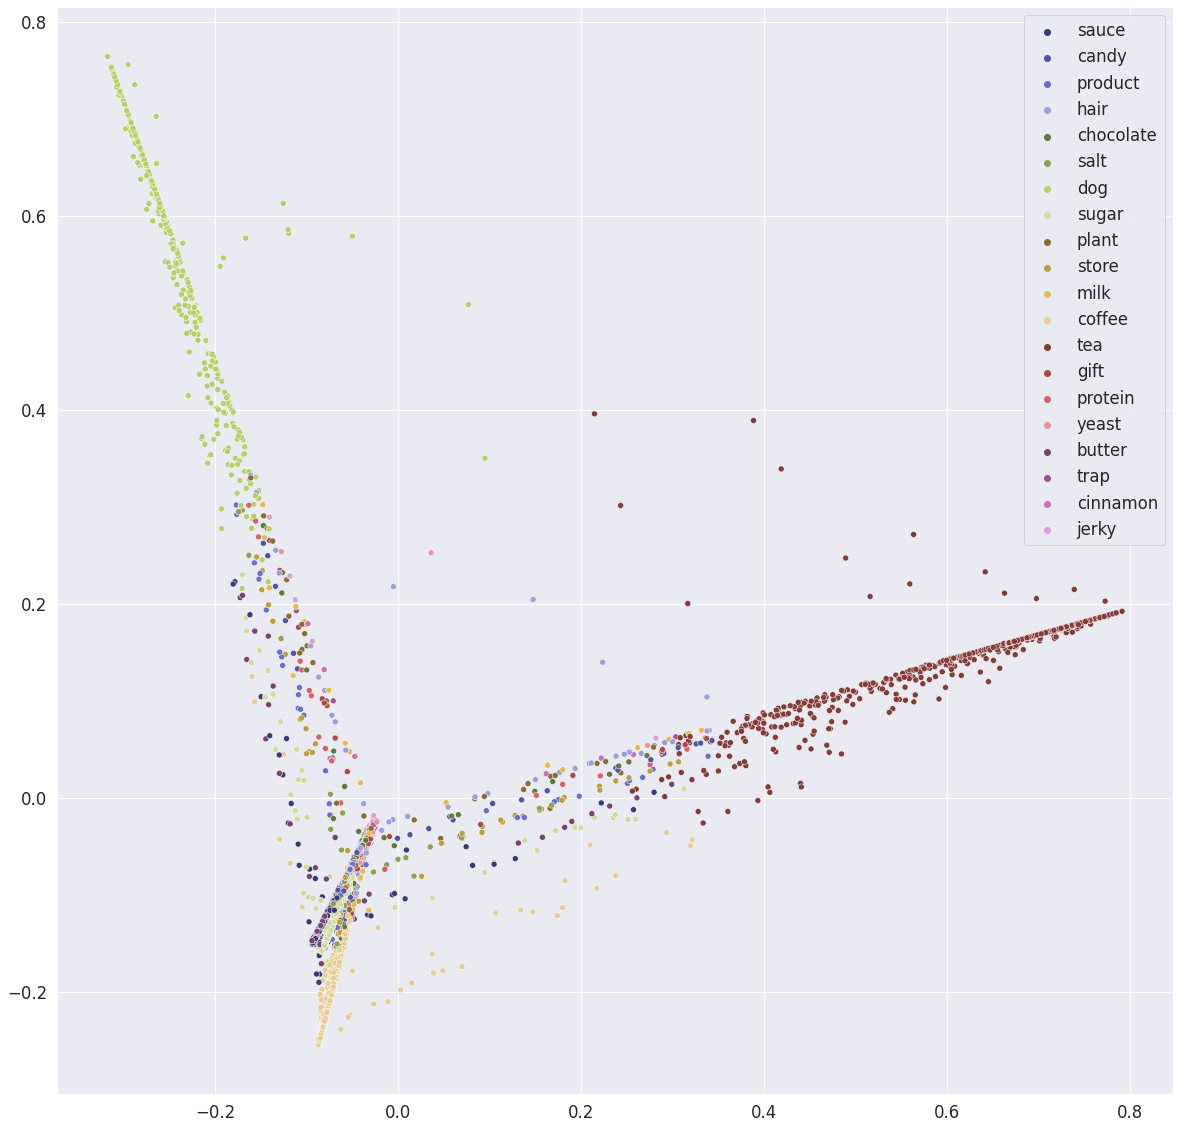

In [75]:
#It takes 11 hours to generate the scatter plot for the full population of good reviews
#just doing a random subset here

start_time = datetime.datetime.now()

#plot_PCA_2D2(docReducedTopicMatrixGR_sub, docTopicMatrixGR_df.iloc[selected_reviews], wordTopicmatrixGR_df, "good_reviews_subset.png")

TOPICS = [ get_topic(row_index,docTopicMatrixGR_df.iloc[selected_reviews],wordTopicmatrixGR_df) for row_index in selected_reviews ]

plt.figure(figsize=(20,20))
ax = sns.scatterplot(x=docReducedTopicMatrixGR_sub[:,0],y=docReducedTopicMatrixGR_sub[:,1],hue=TOPICS, palette="tab20b")
plt.savefig("../Documents/Images/good_reviews_subset.png",dpi=400)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))
#Y_COLOR

This is a plot of 7000 (or whatever `review_subset_size`  is set to ) good review documents. The (x,y) coordinates for each dot (document) comes from `docReducedTopicMatrixGR_sub` which is `docTopicMatrixGR` PCA reduced from 20 to 2 components.

The plot shows that the reviews discuss tea, dogs which supports findings in the earlier LDA visualizations. The reviews are not linearly separable in two dimensions.


#### Bad Reviews
Now let's check the quality of results of the topic generation by finding the reviews that scored best in the `docTopicMatrixBR_df`

##### Eye-Ball Checking Text

In [76]:
docTopicMatrixBR = LD_AllocatorTFIDFBR.transform(docTermMatrixTFIDFBR)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
docTopicMatrixBR_df = pd.DataFrame(docTopicMatrixBR).add_prefix("topic_")
docTopicMatrixBR_df[["Summary","ProcessedText","Text","Score"]] = bad_reviews_df[["Summary","ProcessedText","Text","Score"]]
docTopicMatrixBR_df.head()

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,Summary,ProcessedText,Text,Score
0,0.010744,0.010744,0.010744,0.010744,0.010744,0.010744,0.010744,0.010744,0.010744,0.010744,...,0.010744,0.010744,0.010744,0.010744,0.795871,0.010744,Cough Medicine,if you be look for the secret ingredient in i ...,If you are looking for the secret ingredient i...,2
1,0.010138,0.010138,0.010138,0.010138,0.010138,0.010138,0.010138,0.010138,0.010138,0.010138,...,0.010138,0.010138,0.010138,0.010138,0.010138,0.010138,My Cats Are Not Fans of the New Food,my have be happily eat platinum for more than ...,My cats have been happily eating Felidae Plati...,1
2,0.014124,0.014124,0.014124,0.014124,0.014124,0.014124,0.014124,0.014124,0.014124,0.014124,...,0.014124,0.014124,0.731646,0.014124,0.014124,0.014124,Nasty No flavor,the candy be just red no flavor just plan and ...,"The candy is just red , No flavor . Just plan...",1
3,0.014473,0.014473,0.725015,0.014473,0.014473,0.014473,0.014473,0.014473,0.014473,0.014473,...,0.014473,0.014473,0.014473,0.014473,0.014473,0.014473,Don't like it,this oatmeal be not good it mushy soft i like ...,"This oatmeal is not good. Its mushy, soft, I d...",1
4,0.018488,0.648735,0.018488,0.018488,0.018488,0.018488,0.018488,0.018488,0.018488,0.018488,...,0.018488,0.018488,0.018488,0.018488,0.018488,0.018488,stale product.,in day and be so stale i could not eat any of the,Arrived in 6 days and were so stale i could no...,1


Picked a topic. Read three or more reviews. If the reviews all appear to be about the same theme, then you can say that the topic was synthesized well by LDA.

In [78]:
#find 5 reviews that score highest in topic_X
for review in docTopicMatrixBR_df.sort_values(by="topic_15",ascending=False).head(1)[["Summary","Score","Text"]].values:
    print(review,"\n")

['I Have Buyers Remorse!' 2
 'I bought this from a brick and mortar baby supply chain, and I was so excited to use it! I peeled, I chopped, I steamed and pureed. I was so happy! Then I realized it took me all day to make one regular sized batch of baby food. Still, it was so easy to just throw it in and walk away, so I kept making my baby food, one tiny batch at a time. Then, the fourth time I tried to use it, it would not steam. The start, stop, and steam buttons do not work. I\'d had the machine less than a month. Then I noticed (as I was dumping out my unused water) that there was a bunch of metallic looking crap floating around in the water chamber. Unfortunatly the box had been thrown away otherwise I would have just taken it back to the store. I emailed customer service and about a week later received an email that said "please provide us with a number to reach you". By looking at some more recent reviews I can see I\'m not the only one having a problem with their customer servic

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


These all appear to be about coffee. So LDA did well in creating this topic and assigning this topic as the largest vector component in the document-topic matrix for these reviews.

In [79]:
bad_review_vocab = tfidfvectorizer_br.get_feature_names()
wordTopicmatrixBR_df = pd.DataFrame(LD_AllocatorTFIDFBR.components_,columns=bad_review_vocab).T.add_prefix("topic_")
#wordTopicmatrixBR_df.head()

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
#(wordTopicmatrixBR_df.sort_values(by="topic_12",ascending=False).head(5))["topic_12"]

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Cluster Plot

In [81]:
pcaBR = PCA(n_components=2, random_state=RANDOM_STATE)
pcaBR.fit(docTopicMatrixBR)
docReducedTopicMatrixBR = pcaBR.transform(docTopicMatrixBR)


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
#Getting top topics to determine PCA components used for plots later
np.argsort(pcaBR.components_[0])

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 1, 15, 18, 10, 17, 13, 11,  8,  2,  7, 16,  3,  4,  5,  0,  9, 19,
       12, 14,  6])

In [83]:
np.argsort(pcaBR.components_[1])

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 1, 10, 17,  7, 11, 13, 16,  5,  2,  3,  8,  9,  0, 19, 12,  4, 14,
        6, 18, 15])

In [84]:
review_subset_size = 7000

numb_of_bad_reviews = docReducedTopicMatrixBR.shape[0]
selected_reviews = np.random.choice(numb_of_bad_reviews,
                                   size=review_subset_size,
                                   replace=True)


docReducedTopicMatrixBR_sub = docReducedTopicMatrixBR[selected_reviews,:]
docTopicMatrixBR_sub = docTopicMatrixBR[selected_reviews,:]

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


time spent doing operation is 0:01:05.417810


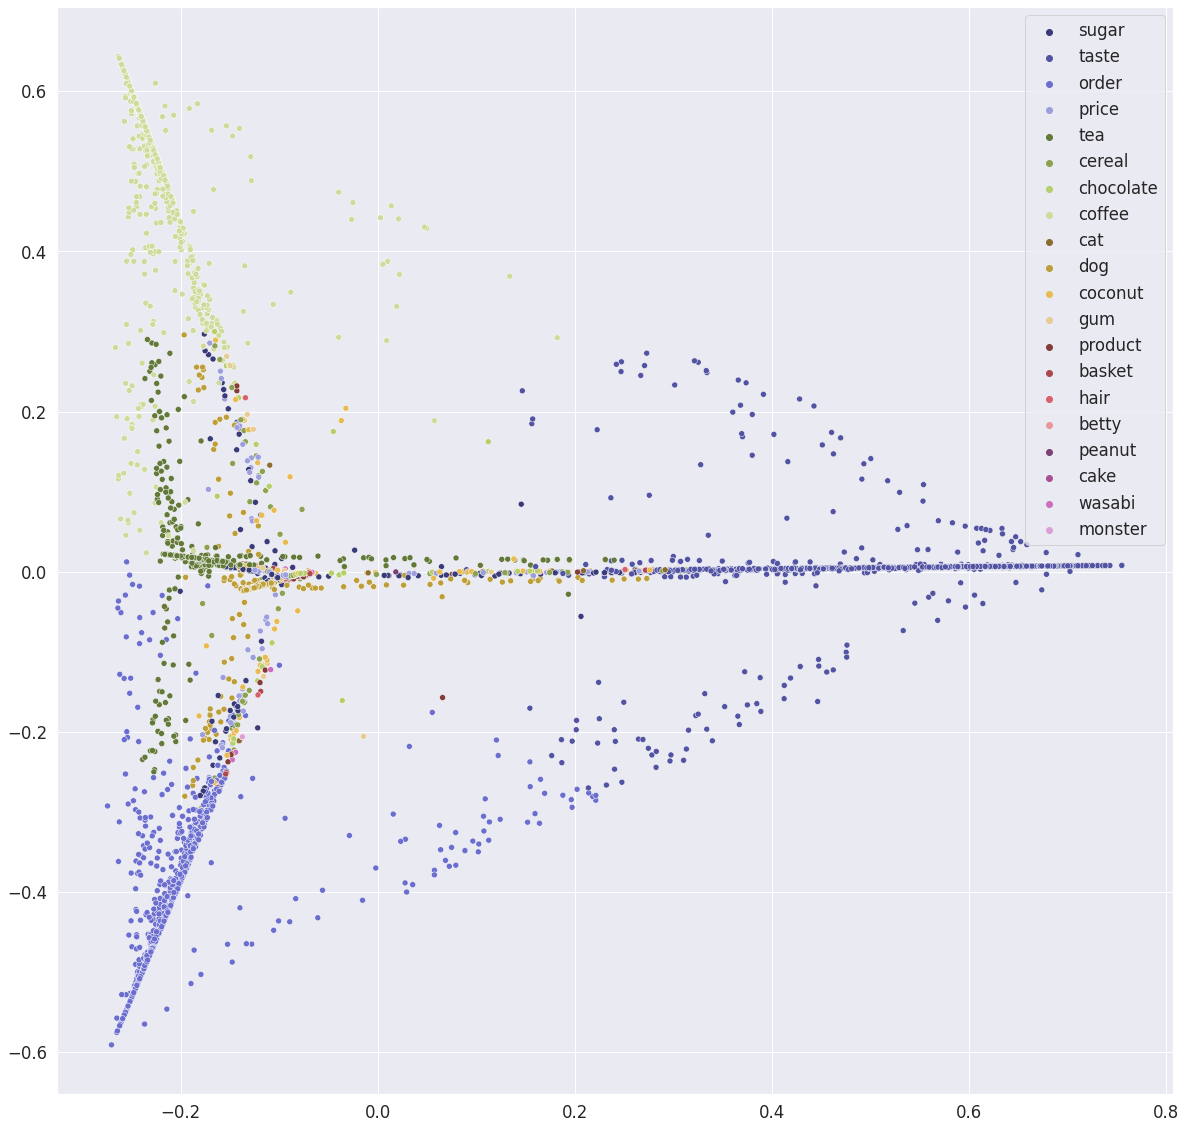

In [85]:
#It takes 11 hours to generate the scatter plot for the full population of good reviews
#just doing a random subset here

start_time = datetime.datetime.now()

TOPICS = [ get_topic(row_index,docTopicMatrixBR_df.iloc[selected_reviews],wordTopicmatrixBR_df) for row_index in selected_reviews ]

plt.figure(figsize=(20,20))
ax = sns.scatterplot(x=docReducedTopicMatrixBR_sub[:,0],y=docReducedTopicMatrixBR_sub[:,1],hue=TOPICS, palette="tab20b")
plt.savefig("../Documents/Images/bad_reviews_subset.png",dpi=400)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

This is a plot of 7000 (or whatever `review_subset_size`  is set to ) good review documents. The (x,y) coordinates for each dot (document) comes from `docReducedTopicMatrixBR_sub` which is `docTopicMatrixBR` PCA reduced from 20 to 2 components.

The plot shows that the reviews discuss taste, coffee, and the orders which supports findings in the earlier LDA visualizations. The reviews are not linearly separable in two dimensions.


#### Full Plots

**Caution**: Running the two cells below can take up to 12 hours to run. I'm protecting them with a option variable below.

In [86]:
if GENERATE_FULL_SCATTER_PLOT:
    
    start_time = datetime.datetime.now()
    
    plt.figure(figsize=(20,20))
    TOPICS = [ get_topic(row_index,docTopicMatrixBR_df,wordTopicmatrixBR_df) for row_index in docTopicMatrixBR_df.index ]
    ax = sns.scatterplot(x=docReducedTopicMatrixBR[:,0],y=docReducedTopicMatrixBR[:,1],hue=TOPICS, palette="tab20b")    
    plt.savefig("../Documents/Images/bad_reviews_full.png",dpi=400)
    
    end_time = datetime.datetime.now()
    print("time spent doing operation is {}".format(end_time - start_time))

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [87]:
if GENERATE_FULL_SCATTER_PLOT:

    start_time = datetime.datetime.now()
    
    plt.figure(figsize=(20,20))
    TOPICS = [ get_topic(row_index,docTopicMatrixGR_df,wordTopicmatrixGR_df) for row_index in docTopicMatrixGR_df.index ]
    ax = sns.scatterplot(x=docReducedTopicMatrixGR[:,0],y=docReducedTopicMatrixGR[:,1],hue=TOPICS, palette="tab20b")    
    plt.savefig("../Documents/Images/good_reviews_full.png",dpi=400)
        
    print("time spent doing operation is {}".format(end_time - start_time))

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


# Component Selection Evaluation
In this section I will perform KMeans clustering of the good and bad reviews and generate a [scree plot](https://en.wikipedia.org/wiki/Scree_plot). The purpose of the scree plotting will be to determine if the number of topics chosen in the PCA analysis performed above explains an adequate amount of variance in the respective reviews.

### Good Review Scree Plot Analysis

In [88]:
docTermMatrixTFIDFBR.shape

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(40420, 15183)

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


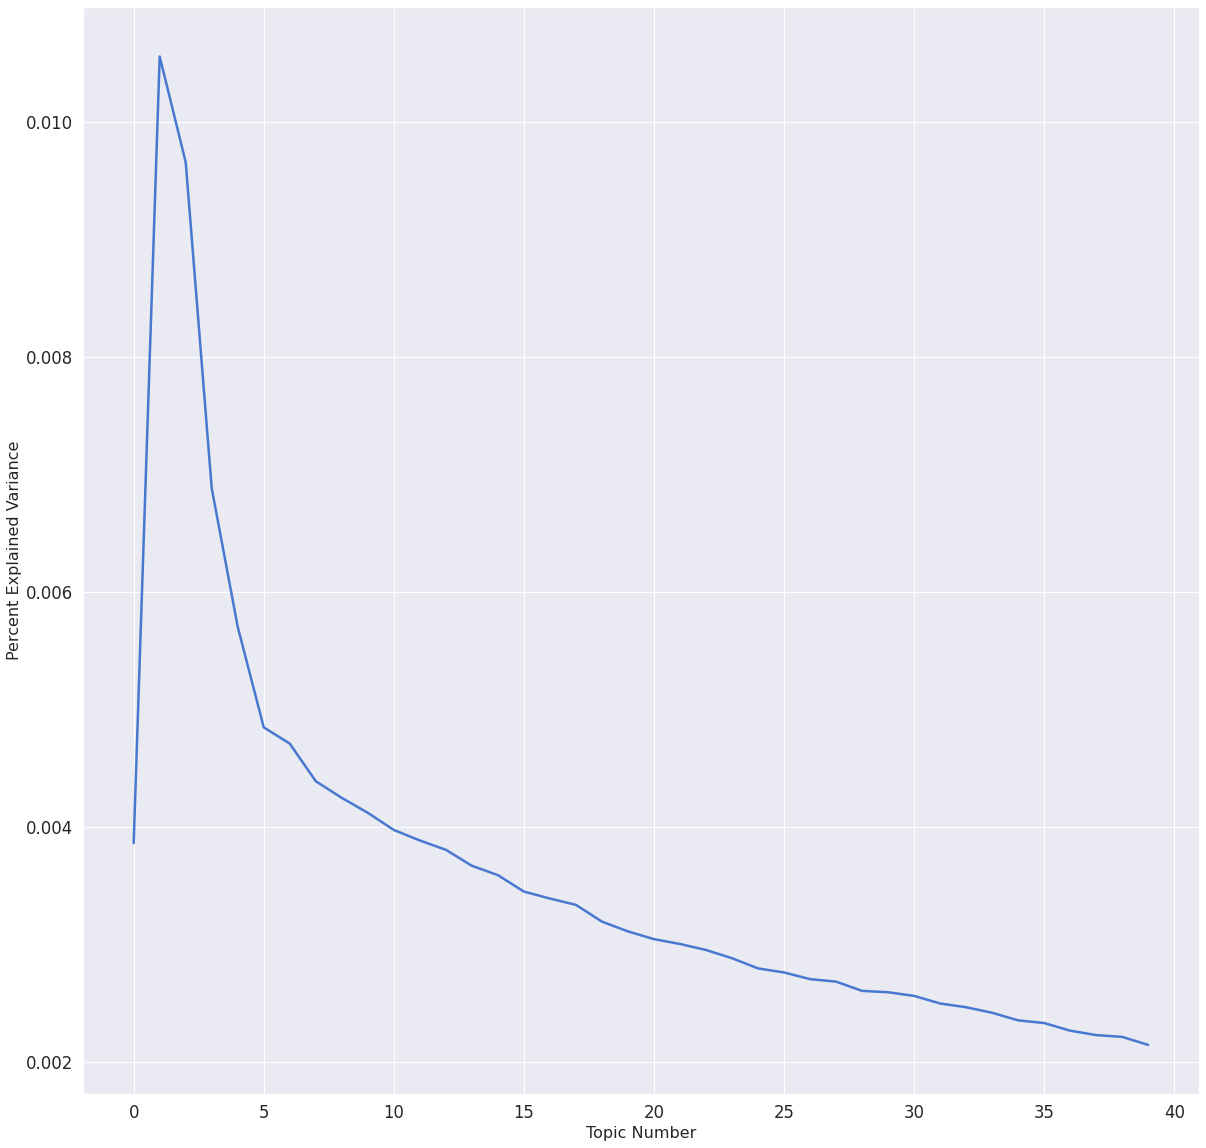

In [89]:
#Using the TFIDF vectorized document term matrix as the data set
pcaGR40 = TruncatedSVD(n_components=40)
pcaGR40.fit(docTermMatrixTFIDFGR)
plt.figure(figsize=(20,20))
plt.plot(pcaGR40.explained_variance_ratio_)
plt.xlabel("Topic Number",fontsize=16)
plt.ylabel("Percent Explained Variance",fontsize=16)
plt.savefig("../Documents/Images/good_reviews_scree_plot.png")
plt.show();


The scree plot indicates that most of the variance can be explained with 5 topics. I selected 20 topics, so this plot indicates that I'm explaining sufficient amount of variance.

The "knee" of the scree plot is at around 5 topics. The biggest reduction in explained variance occured up until the number of topics is 5. There is an improvement beyond topic 5, but the amount of improvement per added topic descreases.

The "knee" of the scree plot is at around 5 topics. The biggest reduction in explained variance occured up until the number of topics is 5. There is an improvement beyond topic 5, but the amount of improvement per added topic descreases.

### Bad Review Scree Plot Analysis

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


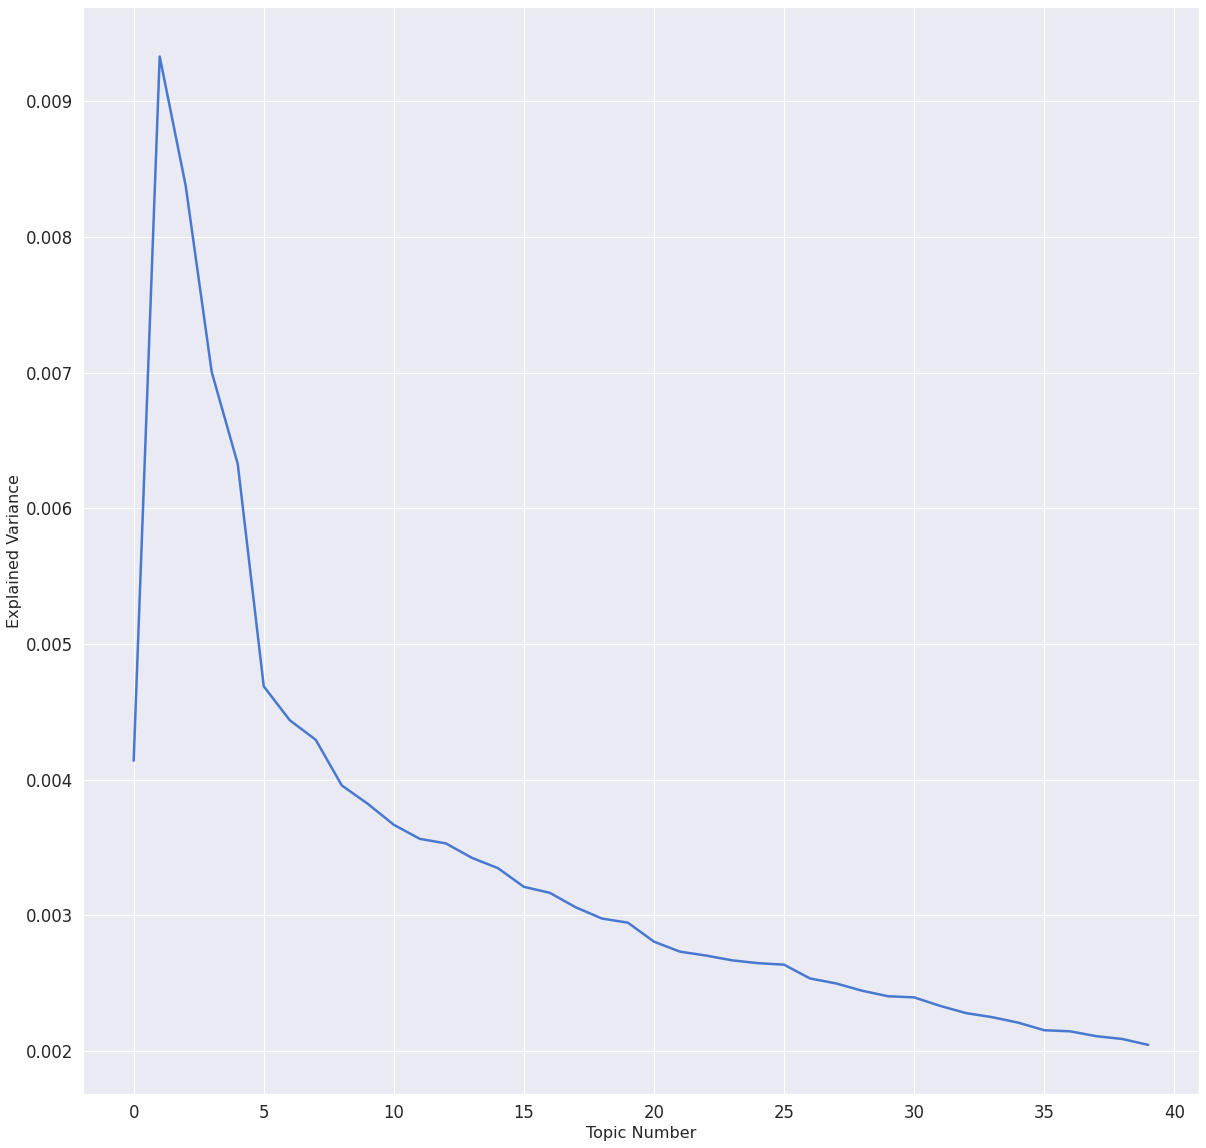

In [90]:
#Using the TFIDF vectorized document term matrix as the data set
pcaBR40 = TruncatedSVD(n_components=40)
pcaBR40.fit(docTermMatrixTFIDFBR)
plt.figure(figsize=(20,20))
plt.plot(pcaBR40.explained_variance_ratio_)
plt.xlabel("Topic Number",fontsize=16)
plt.ylabel("Explained Variance",fontsize=16)
plt.savefig("../Documents/Images/bad_reviews_scree_plot.png")
plt.show();


The scree plot indicates that most of the variance can be explained with 5 topics. I selected 20 topics, so this plot indicates that I'm explaining sufficient amount of variance.

The "knee" of the scree plot is at around 5 topics. The biggest reduction in explained variance occured up until the number of topics is 5. There is an improvement beyond topic 5, but the amount of improvement per added topic descreases.

# Conclusion

We can use this notebook to compare / contrast good vs bad reviews on the same topic to more quickly determine what could be right or wrong about the products described within said reviews.

Example here are 3 good and bad reviews on the "coffee" topic:


In [91]:
for review in docTopicMatrixGR_df.sort_values(by="topic_15",ascending=False).head(3)[["Summary","Score","Text"]].values:
    print(review,"\n")

['Great replacement for Coffee, Easy on stomach' 5
 'After having to give up coffee, and really missing being able to sip a nice hot mug of java each morning, I found reviews for Teeccino. I bought first a small box of the "Tee Bags." As soon as I opened the envelope, the smell was rich and wonderful. The prepared beverage was very good and I enjoyed it so much! So I ventured out again to get a bag of the "loose" grounds that you "brew" like you would coffee. Again, I was VERY pleased! I find the aroma and flavor to be very satisfying. Better than the "cold brew" coffee I had been trying to drink.<br /><br />I read some reviews likening this product to "Postum." I found something like Postum at my health food store called "Kaffree Roma" which is made by Kellogg\'s. It is an instant beverage with similar ingredients to the Teeccino. So I tried that as well. I did not think it was quite as good as the Teeccino. The flavor of the Roma was a bit sesame-like.<br /><br />I highly recommend t

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
for review in docTopicMatrixBR_df.sort_values(by="topic_15",ascending=False).head(3)[["Summary","Score","Text"]].values:
    print(review,"\n")

['I Have Buyers Remorse!' 2
 'I bought this from a brick and mortar baby supply chain, and I was so excited to use it! I peeled, I chopped, I steamed and pureed. I was so happy! Then I realized it took me all day to make one regular sized batch of baby food. Still, it was so easy to just throw it in and walk away, so I kept making my baby food, one tiny batch at a time. Then, the fourth time I tried to use it, it would not steam. The start, stop, and steam buttons do not work. I\'d had the machine less than a month. Then I noticed (as I was dumping out my unused water) that there was a bunch of metallic looking crap floating around in the water chamber. Unfortunatly the box had been thrown away otherwise I would have just taken it back to the store. I emailed customer service and about a week later received an email that said "please provide us with a number to reach you". By looking at some more recent reviews I can see I\'m not the only one having a problem with their customer servic

/home/magreen/anaconda3_2020_07/envs/metis_linux_venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


As you can see, people who like coffee like it because it's "aromatic","nice", and "bold". People dislike their coffee because it's "metallic","sour" and "taste like you just drank contents of an ashtray." This took very little time to ascertain compared to having to (1) search for reviews on the topic of coffee, and then (2) find a positive review about coffee and a negative review about coffee.